In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis

### Ejercicio preliminar para comparar con las mezclas de analizadores de factores.

Entrenamos un analizador de factores con 5000 muestras del conjunto MNIST.

In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, cache=True)

In [ ]:
data = X[:5000]
data.shape

(5000, 784)

Utilizamos 20 factores ocultos. Los mostramos (y también la media).

In [ ]:
fa = FactorAnalysis(n_components=20)
fa.fit(data)

FactorAnalysis(n_components=20)

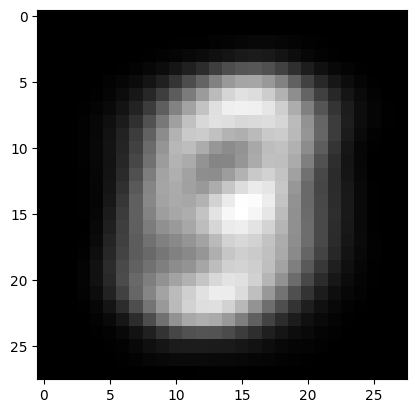

In [ ]:
plt.imshow(fa.mean_.reshape(28,28), cmap = 'gray')

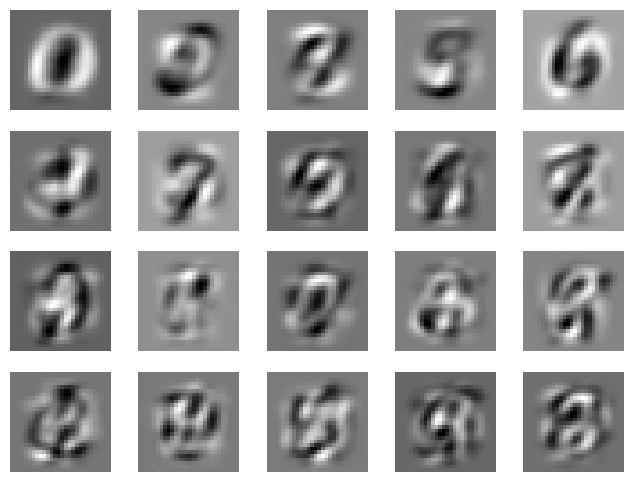

In [ ]:
fig, axs = plt.subplots(4,5, figsize=(8,6))
for i in range(4):
    for j in range(5):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(fa.components_[i*5+j].reshape(28,28), cmap='gray')

Tomemos unos cuantos dígitos, llevémoslos al espacio latente, reconstruyámoslos y comparémoslos con el original.

In [ ]:
num = 10
digs = data[:num,:].T # Los 10 primeros dígitos de nuestro conjunto.

El analizador de factores proporciona una distribución de probabilidad $p(h | v)$ que nos permite obtener las componentes latentes $h$ que corresponden a un dato $v$. Puesto que el modelo es probabilístico, las componentes no están unívocamente determinadas.

La fórmula aparece en la sección 28.3.1.2 del libro de Murphy, donde se usa $\mathbf{z}$ en vez de $h$ y $\mathbf{x}$ en vez de $v$:
$$p(\mathbf{z}| \mathbf{x}) = \mathcal{N}(\mathbf{z} | \boldsymbol{\mu}_{z|x},\mathbf{\Sigma}_{z|x})$$

con
- $\mathbf{\Sigma}_{z|x} = (\mathbf{I} + \mathbf{W}^T\boldsymbol{\Psi}^{-1}\mathbf{W})^{-1}$.
- $\boldsymbol{\mu}_{z|x} = \mathbf{\Sigma}_{z|x} \mathbf{W}^T\boldsymbol{\Psi}^{-1}(\mathbf{x}-\boldsymbol{\mu})$.

En la notación de Barber, $\mathbf{W}$ es $\mathbf{F}$.

Para generar las componentes ocultas será suficiente con calcular la media $\boldsymbol{\mu}_{z|x}$ de la distribución anterior (que es el valor más probable de dicha componente).

In [ ]:
# Calculamos los factores necesarios para calcular la media.
W = fa.components_.T
# Esto es la covarianza Sigma, que interviene en mu.
cov = np.eye(W.shape[1]) + W.T @ np.linalg.inv(fa.get_covariance()) @ W

aux = cov @ W.T @ np.linalg.inv(fa.get_covariance())

In [ ]:
l_digs = np.zeros((20,num)) # Para guardar las componentes latentes
r_digs = np.zeros((784,num)) # Para guardar la reconstrucción de los dígitos
mu = np.mean(data, axis=0)
for i in range(num):
    x = digs[:, i]  # Una columna de digs
    # Calcular las componentes latentes (mu_z|x)
    l_digs[:, i] = aux @ (x - mu)
    # Reconstruir el dígito desde las componentes latentes
    r_digs[:, i] = W @ l_digs[:, i] + mu

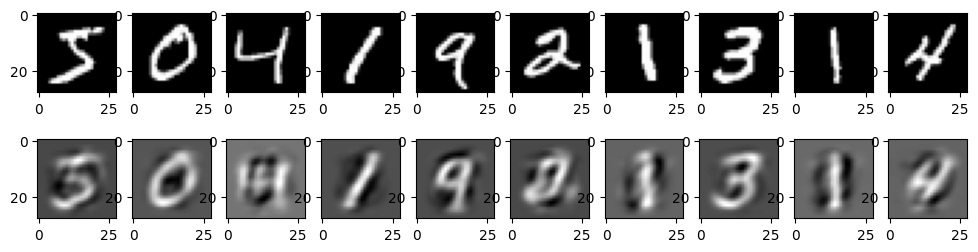

In [ ]:
fig, axs = plt.subplots(2,num, figsize=(12,3))
for i in range(num):
    axs[0,i].imshow(digs[:,i].reshape(28,28), cmap='gray')
    axs[1,i].imshow(r_digs[:,i].reshape(28,28),cmap='gray')

### PCA
Vamos a repetir los mismos pasos pero utilizando PCA en lugar de FA. El número de componentes principales también será 20.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 20)
h = pca.fit_transform(data) # Estas ya son las coordenadas con respecto
                            # a las componentes principales: las "variables ocultas"

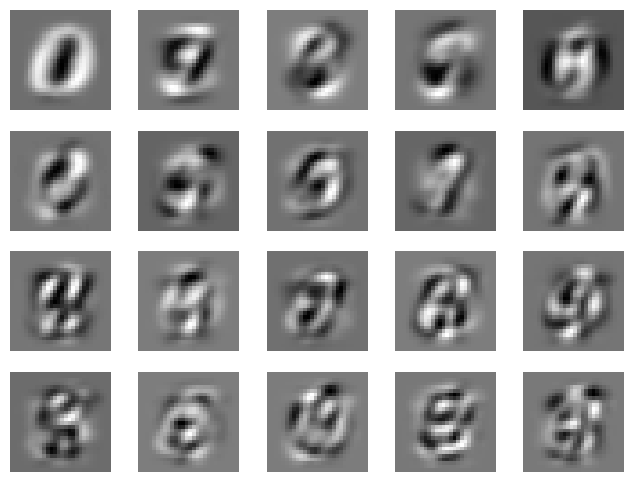

In [ ]:
fig, axs = plt.subplots(4,5, figsize=(8,6))
for i in range(4):
    for j in range(5):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(pca.components_[i*5+j].reshape(28,28), cmap='gray')

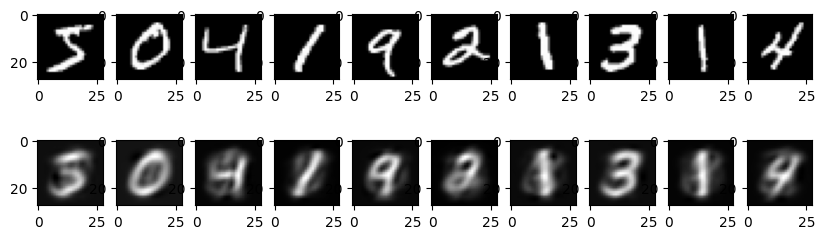

In [ ]:
# Las 5 primeras posiciones de h son las "componentes" de los
# 5 primeros dígitos que estamos utilizando.
reconstructed = h @ pca.components_ + pca.mean_
fig, axs = plt.subplots(2,num, figsize=(num,3))
for i in range(num):
    axs[0,i].imshow(digs[:,i].reshape(28,28), cmap='gray')
    axs[1,i].imshow(reconstructed[i].reshape(28,28)+data.reshape((5000,28,28)).mean(axis=0), cmap='gray')

### Cuestiones
Compara los resultados obtenidos con FA y PCA y analízalos. Compáralos también con la mezcla de Bernoullis de la tarea anterior (que encontraba distintos "estilos" de dígitos) y con el ejercio 1 de esta misma tarea. ¿Cuáles podrían ser las ventajas de FA frente a PCA, si es que tiene alguna?

### Comparación entre FA y PCA

- **PCA**:
  - **Objetivo**: Maximizar la varianza explicada.
  - **Método**: Calcula combinaciones lineales de las variables originales.
  - **Ventajas**: Rápido, fácil de interpretar, efectivo para reducción de dimensionalidad.
  - **Limitaciones**: No modela factores latentes, solo preserva la varianza.

- **FA**:
  - **Objetivo**: Modelar factores latentes que explican las correlaciones.
  - **Método**: Utiliza variables latentes para explicar las observaciones.
  - **Ventajas**: Captura estructuras subyacentes, más interpretable en algunos contextos.
  - **Limitaciones**: Puede no retener tanta varianza como PCA.

### Comparación con la Mezcla de Bernoullis
- **Mezcla de Bernoullis**: Utilizada para identificar "estilos" de dígitos en un modelo generativo.
  - **Ventajas**: Flexible, captura distribuciones complejas.
  - **Comparación**: Mientras PCA y FA son técnicas lineales, la mezcla de Bernoullis permite modelar distribuciones más ricas y variados patrones.

### Ventajas de FA frente a PCA
- **Interpretación más rica**: FA modela factores latentes y puede proporcionar una representación más explicativa.
- **Manejo de relaciones complejas**: Es más adecuado cuando hay estructuras subyacentes no observadas, mientras que PCA solo maximiza la varianza sin capturar estos patrones.
